# Rice Disease Recognition

Ce programme utilise des photos de plants de riz pour déterminer si la plante est saine ou malade, ainsi que pour identifier l'affliction probable le cas échéant. Les plants sont classés en 5 catégories: 4 catégorie pour différentes maladies (Bacterial Blight Disease, Blast Disease, Brown Spot Disease, False Smut Disease) et 1 catégorie pour les plants sains (Healthy). Les photos du batch d'entrainement étant labélisées, il s'agit donc d'un problème de classification avec apprentissage supervisé. C'est pourquoi un CNN est utilisé pour cet exercice.

__Sources et liens__

Les images sont tirées de deux sources sur Kaggle:

Les photos de plants sains sont tirées de la contribution suivante: https://www.kaggle.com/datasets/rajkumar898/rice-plant-dataset/data

Les photos des plants malades proviennent de la page suivante: https://www.kaggle.com/datasets/thegoanpanda/rice-crop-diseases

Une partie du code a été inspirée par la contribution sur cette page d'un autre utilisateur: https://www.kaggle.com/code/muhammadfaizan65/rice-crop-diseases-classification-using-vgg16

Afin d'éviter une surreprésentation des plants sains (500 photos) par rapport aux plants malades (200 photos), seules les 200 premières photos du dossier "Healthy" sont retenues pour cet exercice.

Le modèle du CNN a été en partie tiré de cette publication dans le Vietnam Journal of Computer Science: https://www.researchgate.net/publication/339234028_Plant_Identification_Using_New_Architecture_Convolutional_Neural_Networks_Combine_with_Replacing_The_Red_of_Color_Channel_Image_by_Vein_Morphology_Leaf

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models

Les images sont réparties en 5 dossiers correspondants aux 5 catégories susmentionnées. (Penser à modifier le chemin "base_dir" vers le dossier correspondant).

In [2]:
# Directory containing the dataset
base_dir = r'C:\Users\Onwer\Desktop\Programmation\Cours Machine Learning\TP\Rice_Diseases'
categories = ['Bacterial Blight Disease', 'Blast Disease', 'Brown Spot Disease', 'False Smut Disease', 'Healthy']

In [3]:
# Load dataset
def load_images(base_dir, categories, img_size=(128, 128)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(category)
    return np.array(images), np.array(labels)

Le nombre d'images dans le batch est confirmé (50 pour chaque maladies, 200 pour les saines).

In [4]:
images, labels = load_images(base_dir, categories)
print("Number of images:", len(images))

Number of images: 400


25 images sélectionnées aléatoirement sont affichées pour confirmer le chargement correct des données et des labels.

In [5]:
# Display sample images
def display_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        idx = np.random.randint(len(images))
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.show()

Les labels sont encodés et les images normalisées pour le processing.

In [6]:
# Data Preprocessing
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

# Normalize images
images = images / 255.0

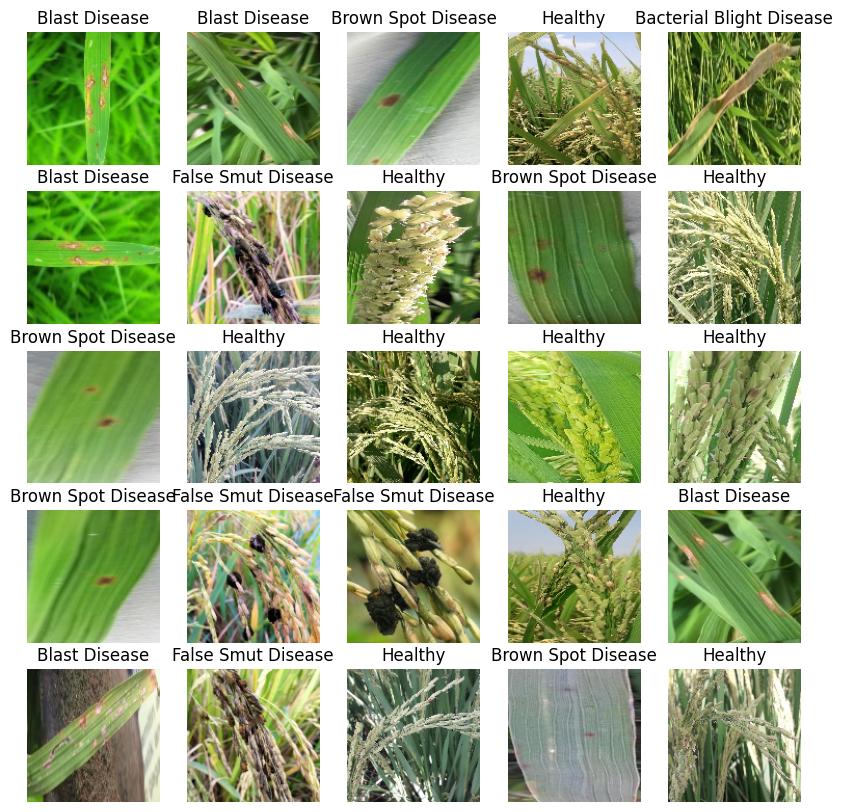

In [7]:
class_names = le.classes_
display_sample_images(images, labels_encoded.argmax(axis=1), class_names)

Les images sont splittées en un batch d'entrainement et un batch de test selon une proportion de 80%-20%.

In [8]:
# Split data
train_images, test_images, train_labels, test_labels = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

Le CNN utilisé emploit deux couches de convolution et deux couches de pooling. Les données sont ensuite passées par une couche "flatten" puis deux couches denses. La dernière couche produit un output avec 5 catégories. Un résumé du modèle est affiché pour s'assurer de la compatibilité des input/output des couches.

In [9]:
# Convolutive base
model = models.Sequential()
model.add(layers.Conv2D(32, (8, 8), strides = (2, 2), activation='relu', input_shape=( 128, 128, 3)))
model.add(layers.MaxPooling2D((7, 7), strides = (2, 2)))
model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((6, 6), strides = (2, 2)))

model.summary()

c:\Users\Onwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 32)     │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,440 (224.38 KB)

 Trainable params: 57,440 (224.38 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Dense layer
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [11]:
# Display the model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 32)     │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,365 (481.89 KB)

 Trainable params: 123,365 (481.89 KB)

 Non-trainable params: 0 (0.00 B)

Le modèle est entrainé sur un nombre défini d'epochs. Pour determiner le nombre optimal d'epoch, nous commençons avec 50 afin d'observer les valeurs de la fonction de cout et de l'accuracy. Ces deux valeurs sont ensuite plottées.

In [15]:
# Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=50, 
                    validation_data=(test_images, test_labels))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6941 - loss: 0.9002 - val_accuracy: 0.7875 - val_loss: 0.5553
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8185 - loss: 0.4887 - val_accuracy: 0.7875 - val_loss: 0.5364
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8762 - loss: 0.4110 - val_accuracy: 0.7750 - val_loss: 0.4685
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8942 - loss: 0.3031 - val_accuracy: 0.8000 - val_loss: 0.4472
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9033 - loss: 0.2543 - val_accuracy: 0.8875 - val_loss: 0.3316
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9162 - loss: 0.2069 - val_accuracy: 0.8875 - val_loss: 0.3280
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9500 - loss: 0.1761 - val_accuracy: 0.8500 - val_loss: 0.3707
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9691 - loss: 0.1249 - val_accuracy: 0.8250 - v

3/3 - 0s - 24ms/step - accuracy: 0.8875 - loss: 0.2871


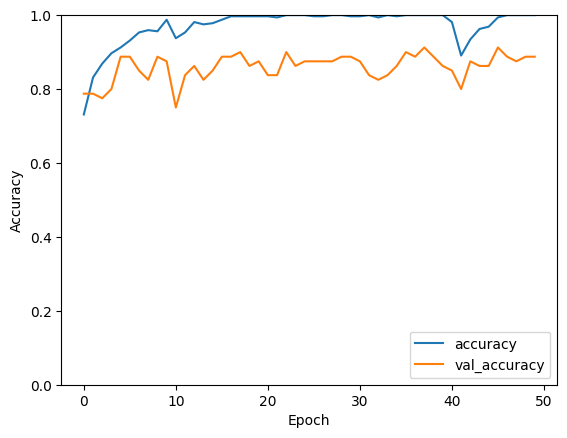

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

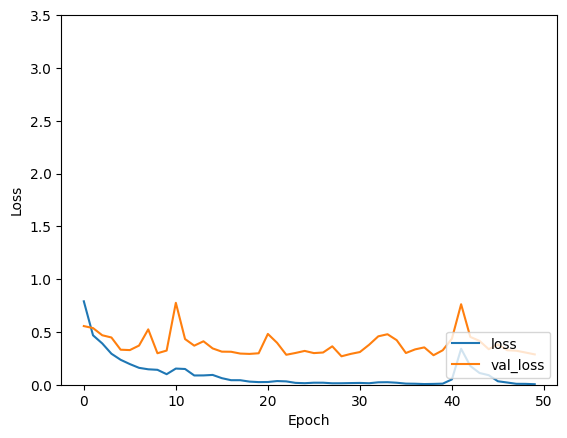

In [17]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3.5])
plt.legend(loc='lower right')

En observant la variation de la fonction de cout en fonction du nombre d'epochs, nous constatons une chute notable dans les 8 premières epochs (0.9002 à 0.1249) suivie d'un plateau. Le même coude se vérifie avec l'accuracy (0.6941 à 0.9500 pour 7 premières epochs). Ainsi, le nombre optimal d'epochs pour éviter le surfitting semble être à 7 ou 8 epochs.

Néanmoins, de fortes variations s'observent entre différents runs. Une cause probable est le faible nombre de données (400 images). Une façon d'y pallier serait d'employer une k-fold cross-validation au lieu d'un simple split 80/20.